# Implementation of a flow through a porous medium
modified by Javier E. Santos and Philipp Spelten


Description: This notebook calculates the steady-state single-phase laminar flow and the permeability of a domain with overlapping spheres

In [1]:
from typing import List, Optional

from matplotlib import pyplot as plt
import torch
import lettuce as lt
import numpy as np
import os

## Define Flow and Boundary Condition

In [2]:
class PeriodicPressureBC(lt.Boundary):
    """According to Ehsan Evati: 'High performance simulation of fluid flow in porous media...'
    """

    def __init__(self, delta_rho: float):
        self.delta_rho = delta_rho

    def __call__(self, flow: 'Flow'):
        flow.f[[1,5,8], 0,:] = (flow.f[[1,5,8], 0,:] + flow.torch_stencil.w[[1,5,8],
        None] * self.delta_rho)
        flow.f[[3,6,7],-1,:] = flow.f[[3,6,7],-1,:] - flow.torch_stencil.w[[3,6,7],None] * self.delta_rho
        # TODO: call flow.collision() as it will otherwise be jumped in 
        #  simulation
        return flow.f

    def make_no_collision_mask(self, shape: List[int], context: 'Context') -> Optional[torch.Tensor]:
        return 

    def make_no_streaming_mask(self, shape: List[int], context: 'Context') -> Optional[torch.Tensor]:
        pass

    def native_available(self) -> bool:
        return False

    def native_generator(self, index: int) -> 'NativeBoundary':
        pass

In [3]:
class PorousMedium2D(lt.Obstacle):
    def __init__(self, context: 'Context', resolution: list[int],
                 reynolds_number, mach_number, domain_length_x, 
                 delta_rho_lu, stencil: 'Stencil'):
        super().__init__(context=context, resolution=resolution, 
                         reynolds_number=reynolds_number, mach_number=mach_number,
                         domain_length_x=domain_length_x, stencil=stencil)
        self.delta_rho_lu = delta_rho_lu
    
    @property
    def boundaries(self):
        return [
            # left/right: push using PeriodicPressureBC
            PeriodicPressureBC(self.delta_rho_lu),
            # periodic in y direction
            lt.BounceBackBoundary(self.mask)
        ]

## Setting up domain and flow parameters

In [4]:
# user-defined parameters for
nx = 512 # domain length in x-dir
ny = 512 # domain length in y-dir

# MASK and ITERATION user-defined parameters for
n_buffer = 10   # number of buffer layers
it_check = 500  # check for convergence of floating avg every n-iterations of it_floating_avg
it_floating_avg = 10 # take avg velocity every n-iterations for the floating avg
avgs_per_check = int(it_check//it_floating_avg)
it_max   = 1e6  # break after max its is reached
epsilon  = 0.1  # break after the diff between its it's less than e %
                # lower epsilon makes no sense, as the avg velocity continues changing

delta_rho_lu = 0.005 # forced pressure differential left and right

In [5]:
# Set up context
context = lt.Context(dtype=torch.float64, use_native=False)
stencil = lt.D2Q9()

# FLOW parameters
Ma    = 0.05 # I set this arbitrarily
u_lbm = stencil.cs*Ma

omega = 1.0
nu    = (1/omega - 0.5)/(1/stencil.cs)**2
Re    = u_lbm*nx/nu
print(Re)

# Set up FLOW
flow = PorousMedium2D(
    context, resolution=[nx, ny], reynolds_number=Re, mach_number=Ma, 
    domain_length_x=nx, delta_rho_lu=delta_rho_lu, stencil=stencil
)

88.68100134752649


Directory './data/porous_example' does not exist. Creating it now...
Directory './data/porous_example' created.


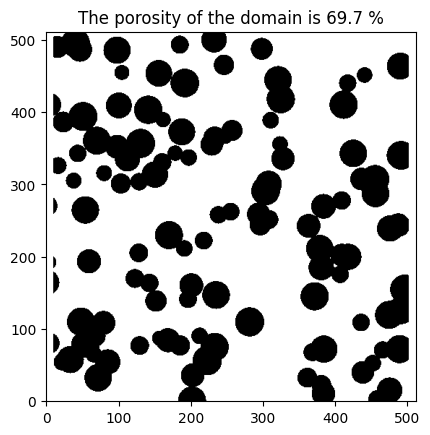

In [6]:
# make porous medium by inserting random CIRCLES
np.random.seed(234269)
n_circles = 125
x, y = flow.grid
for i in range(n_circles):
    x0 = np.random.rand()
    y0 = np.random.rand()
    r = 0.02 + 0.02 * np.random.rand() # radius between 0.02 and 0.04
    x0 = x0*nx
    y0 = y0*nx
    r = r*nx
    circle = ((x-x0)**2 + (y-y0)**2 < r**2)
    flow.mask[circle] = 1

# make a BUFFER region on left and right without obstacles
flow.mask[ :n_buffer, :] = 0
flow.mask[-n_buffer:, :] = 0

# calculate porosity
phi = 1-torch.sum(flow.mask)/(nx*ny)

# Show MASK
plt.imshow(context.convert_to_ndarray(flow.mask.T), 
           origin="lower", cmap='gray_r')
plt.title(f'The porosity of the domain is {phi*100:2.1f} %')

directory = './data/porous_example'

if not os.path.exists(directory):
    print(f"Directory '{directory}' does not exist. Creating it now...")
    os.makedirs(directory)
    print(f"Directory '{directory}' created.")
else:
    print(f"Directory '{directory}' already exists.")

# Set up SIMULATION
collision  = lt.KBCCollision(tau=flow.units.relaxation_parameter_lu)
simulation = lt.Simulation(flow, collision, [])
simulation.reporter.append(lt.VTKReporter(interval=2, filename_base=directory+"/out"))

## Run Simulation

In [7]:
# u_avg is the average velocity over the last couple of time steps
u_avg = [np.inf]
for i in range(1,int(it_max//it_check)):
    u_avg_new = 0
    for j in range(it_floating_avg):
        simulation(avgs_per_check)
        # print(flow.u().mean())
        u_avg_new += flow.u().mean()
    u_avg_new = u_avg_new/it_floating_avg
    u_avg.append(u_avg_new)
    rel_change = ((u_avg[-1]-u_avg[-2])/u_avg[-1]*100).abs()
    print(f'it {i*it_check} u_avg[-1] = {u_avg[-1]} the relative change in mean vel is {rel_change} %')
    if rel_change < epsilon or not u_avg[-1] == u_avg[-1]:
        break

it 500 u_avg[-1] = 0.009691138791684406 the relative change in mean vel is inf %
it 1000 u_avg[-1] = 0.009739418591561515 the relative change in mean vel is 0.4957154210307779 %


KeyboardInterrupt: 

In [ ]:
u_plot = [context.convert_to_ndarray(_) for _ in u_avg[1:]]
plt.plot(np.log10(np.abs(u_plot)))
plt.xlabel(f'{it_check} iterations')
plt.ylabel(f'mean log10(|velocity|) [lus]')

In [ ]:
u = context.convert_to_ndarray(flow.u_pu)
k = nu*u.mean()/(delta_rho_lu/nx)**2
p = context.convert_to_ndarray(flow.p_pu)
unorm = np.linalg.norm(u, axis=0)

# Plot without outliers due to bounce-back contacts
fig, axes = plt.subplots(1,4, figsize=(12,3), dpi=300)
fig.tight_layout()
axes[0].set_title("Pressure")
axes[0].imshow(p[0].transpose(), origin="lower", )#vmin=p[0,ny-1,0], vmax=p[0].mean(axis=-1).max())
axes[1].set_title("Velocity")
axes[1].imshow(unorm.transpose(), origin="lower", cmap='inferno',
               vmin=np.percentile(unorm.flatten(),1),
               vmax=np.percentile(unorm.flatten(),95)
              )
axes[2].set_title("Mean fluid pressure along x")
axes[2].plot(p[0].sum(axis=-1)/(np.logical_not(context.convert_to_ndarray(flow.mask)).sum(axis=-1)))
axes[3].set_title("Mean fluid velocity along x")
axes[3].plot(u[0].mean(axis=-1));


In [ ]:
print(f'Porosity = {phi*100} % and Permeability = {k} [m^2]')